In [1]:
%matplotlib inline

# Torch
import torch
from torch.utils.data import DataLoader
from torch import optim, nn

# Custom
import data
import model
import utils

In [2]:
"""
Data Split for First Layer classification task (normal vs infected) 
"""

fl_labels = {
0 : "Normal",
1 : "Infected"
}

fl_train = data.Lung_Dataset('train', verbose = 0)
fl_test = data.Lung_Dataset('test', verbose = 0)
fl_val = data.Lung_Dataset('val', verbose = 0)

"""
Data Split for Second Layer classification task (COVID vs Non-COVID) 
"""

sl_labels = {
0 : "COVID",
1 : "Non-COVID"
}

sl_train = data.Lung_Dataset('train', verbose = 2)
sl_test = data.Lung_Dataset('test', verbose = 2)
sl_val = data.Lung_Dataset('val', verbose = 2)

"""
Data Split for combined classification task (normal vs COVID vs Non-COVID) 
"""

combined_labels = {
0 : "Normal",
1 : "COVID",
2 : "Non-COVID"
}

final_test = data.Lung_Dataset('test', verbose = 1)
final_val = data.Lung_Dataset('val', verbose = 1)

In [3]:
def main():
    N_EPOCH = 200
    L_RATE = 0.001
    BATCH_SIZE = 32
    PATIENCE = 5
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    fl_train_loader = DataLoader(fl_train, batch_size=BATCH_SIZE, shuffle=True)
    fl_val_loader = DataLoader(fl_val, batch_size=BATCH_SIZE, shuffle=True)
    fl_test_loader = DataLoader(fl_test, batch_size=BATCH_SIZE, shuffle=True)
    
    fl_model = model.CNN().to(device)
    fl_optimizer = optim.Adam(fl_model.parameters(), lr=L_RATE)
    
    print("Training the first model to classify normal and infected images")
    model.train(fl_model, device, nn.BCELoss(), fl_optimizer, fl_train_loader, fl_val_loader, N_EPOCH, PATIENCE, "fl")

    print("\n\n")
    print("Test Accuracy of the first model:")
    model.test(fl_model, device, fl_test_loader)

    fl_model.to("cpu")
    
    model.save_model(fl_model, fl_optimizer, './saved_models/fl_model.pth')
    
    #Second Model
    sl_train_loader = DataLoader(sl_train, batch_size=BATCH_SIZE, shuffle=True)
    sl_val_loader = DataLoader(sl_val, batch_size=BATCH_SIZE, shuffle=True)
    sl_test_loader = DataLoader(sl_test, batch_size=BATCH_SIZE, shuffle=True)
    
    sl_model = model.CNN().to(device)
    
    sl_optimizer = optim.Adam(sl_model.parameters(), lr=L_RATE)
    
    print("\n\n")
    print("Training the second model to classify COVID and non-COVID images")
    model.train(sl_model, device, nn.BCELoss(), sl_optimizer, sl_train_loader, sl_val_loader, N_EPOCH, PATIENCE, "sl")
    
    print("\n\n")
    print("Test Accuracy of the second model:")
    model.test(sl_model, device, sl_test_loader)
    
    sl_model.to("cpu")
    
    model.save_model(sl_model, sl_optimizer, './saved_models/sl_model.pth')
    
if __name__ == '__main__':
    pass
    #main()

In [4]:
"""
Soo Han's own testing code. can delete away
"""

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
L_RATE = 0.001

fl_model = model.CNN().to(device)
fl_optimizer = optim.Adam(fl_model.parameters(), lr=L_RATE)
fl_model, fl_optimizer = model.load_model(fl_model, fl_optimizer, './saved_models/fl_model.pth',device)

sl_model = model.CNN().to(device)
sl_optimizer = optim.Adam(sl_model.parameters(), lr=L_RATE)
sl_model, sl_optimizer = model.load_model(sl_model, sl_optimizer, './saved_models/sl_model.pth',device)

# fl_test_loader = DataLoader(fl_test, batch_size=32, shuffle=True)
# sl_test_loader = DataLoader(sl_test, batch_size=32, shuffle=True)
final_test_loader = DataLoader(final_test, batch_size=32, shuffle=True)
final_val_loader = DataLoader(final_val, batch_size=32, shuffle=True)

# sl_model.eval()
# model.test(sl_model, device, sl_test_loader)

In [5]:
combined_model = model.combine_models('./saved_models/fl_model.pth','./saved_models/sl_model.pth',device,L_RATE)
#combined_model.test_combine(device, final_test_loader, print_acc = True)

tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], device='cuda:0')
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0

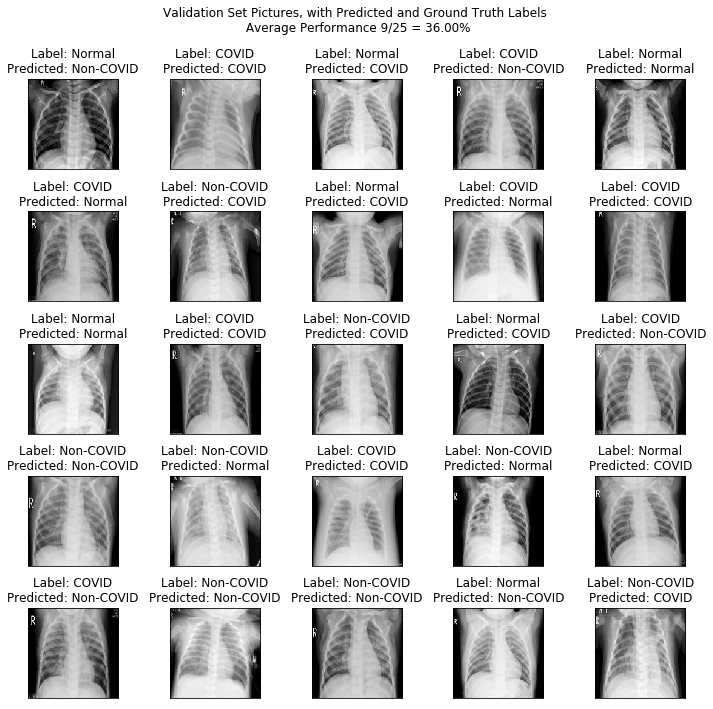

In [6]:
pred = combined_model.test_combine(device, final_val_loader, return_results = True)
utils.generate_performance_display(final_val_loader, pred,combined_labels )